# Prédiction et analyses

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, jaccard_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from predict import *


In [128]:
img_file = 'CYEG_ortho_6_19.png'
#img_file = 'CYEG_ortho_19_12.png'
img_dir = './data/imgs/'
mask_dir = './data/masks/'
prediction_dir = './predictions/'
prediction_name = "{}_OUT{}".format(os.path.splitext(img_file)[0], os.path.splitext(img_file)[1])
prediction_path = os.path.join(prediction_dir, prediction_name)

In [129]:
scale = 1
n_classes = 4
save_results = False
#net_path = './runs/Mar09_12-41-18_pie-cartographie-2LR_0.015_BS_50_SCALE_0.6/checkpoints/CP_epoch42.pth'
#net_path = './runs/CP_epoch28.pth'
net_path = './runs/Mar10_09-30-40_pie-cartographie-2LR_0.01_BS_80_SCALE_0.5/CP_epoch50.pth'

In [130]:
mask_true = np.array(Image.open(os.path.join(mask_dir,img_file)))
labels = np.unique(mask_true)
net = UNet(n_channels=3, n_classes=n_classes)
device = torch.device('cpu')
net.to(device=device)
net.load_state_dict(torch.load(net_path, map_location=device))
img = Image.open(os.path.join(img_dir,img_file))
mask = predict_img(net=net,
                   full_img=img,
                   scale_factor=scale,
                   device=device)
mask = np.argmax(mask, axis=0)


if save_results:
    result = mask_to_image(mask,n_classes)
    result.save(prediction_path)
    


In [131]:
print(np.unique(np.array(mask_to_image(mask,n_classes)),return_counts = True))
print(np.unique(np.array(mask_to_image(mask_true,n_classes)),return_counts = True))

(array([  0,  85, 170, 255], dtype=uint8), array([47297,   236, 17631,   372]))
(array([  0, 170], dtype=uint8), array([45122, 20414]))


# Affichage de la prédiction 

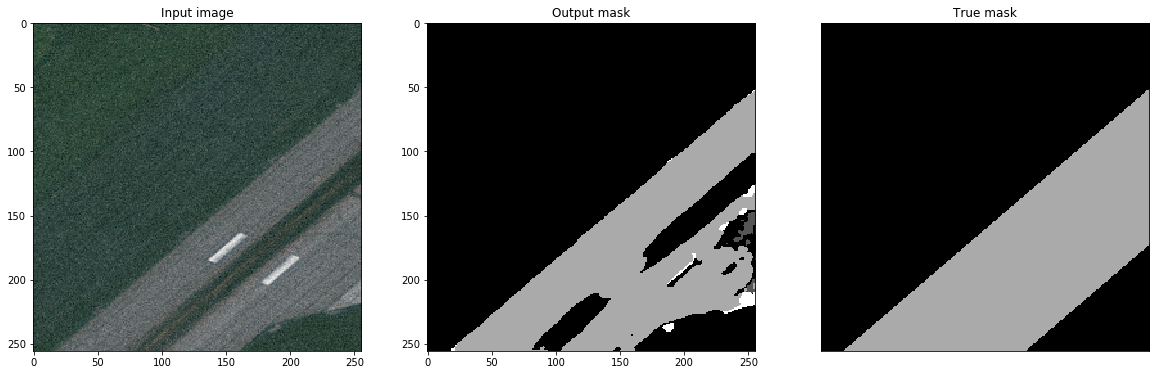

In [132]:
fig, ax = plt.subplots(1, 3,figsize=(20, 10))
ax[0].set_title('Input image')
ax[0].imshow(img)
ax[1].set_title(f'Output mask')
ax[1].imshow(mask_to_image(mask,n_classes),cmap = 'gray',vmin = 0, vmax = 255)
ax[2].set_title(f'True mask')
ax[2].imshow(mask_to_image(mask_true,n_classes),cmap = 'gray',vmin = 0, vmax = 255)
plt.xticks([]), plt.yticks([])
plt.show()

# Confusion matrix

In [109]:
cm = confusion_matrix(mask_true.flatten(),mask.flatten(),labels = labels)

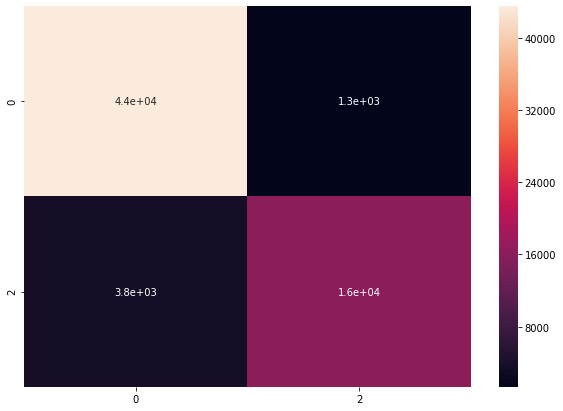

In [110]:
df_cm = pd.DataFrame(cm,index = labels,columns = labels)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.show()

# Jaccard index - Intersection over Union

In [111]:
js = jaccard_score(mask_true.flatten(),mask.flatten(), average = None,labels = labels)
js_df = pd.DataFrame(js,index = labels, columns = ['IoU'])



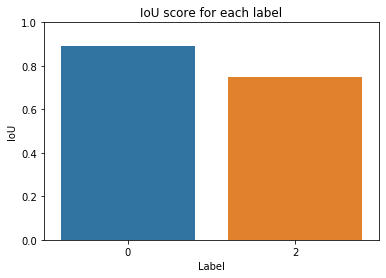

In [112]:
ax = sns.barplot(x=js_df.index,y='IoU',data=js_df)
ax.set(ylim=(0,1))
ax.set_xlabel('Label')
ax.set_title('IoU score for each label')
plt.show()
